# Demo: Masks

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # first gpu


import jax
# again, this only works on startup!
from jax import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')

In [2]:
import autoroot
import jax
import jax.numpy as jnp
from somax.masks import (
    MaskGrid
)
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def init_mask_node_rect(n: int=10, init: str="node"):
    mask = jnp.ones((n,n))
    mask = mask.at[0].set(0.0)
    mask = mask.at[-1].set(0.0)
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    masks = MaskGrid.init_mask(mask, init)
    return masks

def init_mask_node_island(n: int=10, init: str="node"):
    mask = jnp.ones((n,n))
    mask = mask.at[0].set(0.0)
    mask = mask.at[-1].set(0.0)
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    mask = mask.at[4:-4,4:-4].set(0.0)
    masks = MaskGrid.init_mask(mask, init)
    return masks

def init_mask_node_channel(n: int=10, init: str="node"):
    mask = jnp.ones((n,3*n//4))
    mask = mask.at[:,0].set(0.0)
    mask = mask.at[:,-1].set(0.0)
    masks = MaskGrid.init_mask(mask, init)
    return masks

def init_mask_center_realish(n: int=10, init: str="center"):
    mask = jnp.ones((n,n))
    mask = mask.at[1,0].set(0.0)
    mask = mask.at[n-1,2].set(0.0)
    mask = mask.at[0,n-2].set(0.0)
    mask = mask.at[1,n-2].set(0.0)
    mask = mask.at[0,n-1].set(0.0)
    mask = mask.at[1,n-1].set(0.0)
    mask = mask.at[2,n-1].set(0.0)
    masks = MaskGrid.init_mask(mask, init)
    return masks

In [5]:
n = 6
masks = init_mask_node_rect(n, "node")

# n = 10
# masks = init_mask_node_island(n)
# 
n = 6
# masks = init_mask_center_realish(n, "center")

In [6]:
masks.center.values_interior.shape

(6, 6)

In [7]:
masks.node[1:-1].values.shape

(4, 6)

### Quasi-Geostrophic Equations

In this example, we will look at how the QG equations reflect this Arakawa C-Grid staggered definition.

$$
\begin{aligned}
\partial_t \omega &= 
- \vec{\boldsymbol{u}}\cdot\nabla\omega\\
&= \partial_x(u\omega) + \partial_y(v\omega) \\
\omega &= \nabla^2\psi\\
\vec{\boldsymbol{u}} &=
\left[-\partial_y u, \partial_x v \right]^\top
\end{aligned}
$$

Here, the potential vorticity (PV) variable, $\omega$, is the principal variable for this PDE and the streamfunction variable, $\psi$, is a variable which influences .... So we can let $\omega$ be the variable in the cell center and $\psi$ can be the variable at the nodes. This is also convenient because the geostrophic gradients of $\psi$ correspond to the zonal and meridional velocities, $u,v$, which directly correspond to the East-West and North-South faces of the cell.


In [8]:
psi = masks.node
u = masks.face_u
v = masks.face_v
q = masks.center

### Visualization

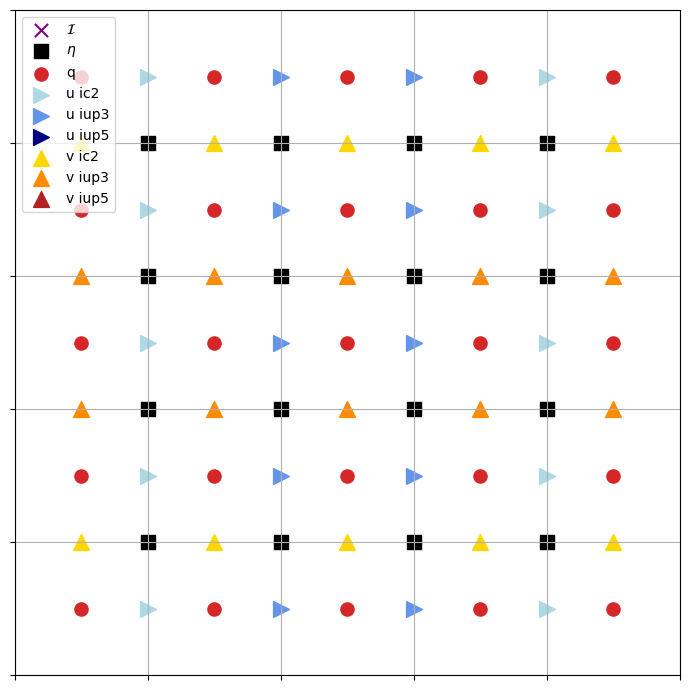

In [9]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(q.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130


# PLOT BOUNDARIES
psi_xmin, psi_ymin = -.5, -.5
ax.scatter(psi_xmin+1+psi.irrbound_xids,psi_ymin+1+psi.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# PLOT STREAM FUNCTION
psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = jnp.argwhere(psi.values.squeeze())
ax.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\eta$', color='black')


# PLOT POTENTIAL VORTICITY
s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = jnp.argwhere(q.values.squeeze())
ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='tab:red')

# PLOT ZONAL VELOCITY
u_xmin, u_ymin = -.5, 0
mask_u_ids = jnp.argwhere(u.distbound1.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(u.distbound2.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(u.distbound3plus.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

# PLOT MERIDIONAL VELOCITY
v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(v.distbound1.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(v.distbound2plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(v.distbound3plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Shallow Water Equations

In this example, we will look at how the Shallow Water Equations are reflected using the Arakawa C-Grid.

We will write out the PDE or the Shallow Water Equations using the vector-invariant formulation which involves the potential vorticity.


In this equation, we will have 3 PDEs given by the height, $h$, and the zonal and meridional velocities, $(u,v)$.

$$
\begin{aligned}
\partial_t h &= 
- \nabla \cdot (\vec{\boldsymbol{u}}h) \\
\partial_t u &=
qhv - \partial_x p + F_x \\
\partial_t v &=
- qhu - \partial_y p + F_y 
\end{aligned}
$$

where $q$ is the potential vorticity and $p$ is the work given by the Bernoulli equation.

We have the two equations

$$
\begin{aligned}
\text{Potential Vorticity}: && && 
q &= \frac{\zeta + f}{h} \\
\text{Bernoulli Work}: && && 
p &= g(h+\eta_b) + \frac{1}{2}(u^2 + v^2) 
\end{aligned}
$$

where $\zeta=\partial_x v - \partial_y u$ is the relative vorticity.

In [10]:
q = masks.node
u = masks.face_u
v = masks.face_v
h = masks.center

In [11]:
h.values

Array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float64)

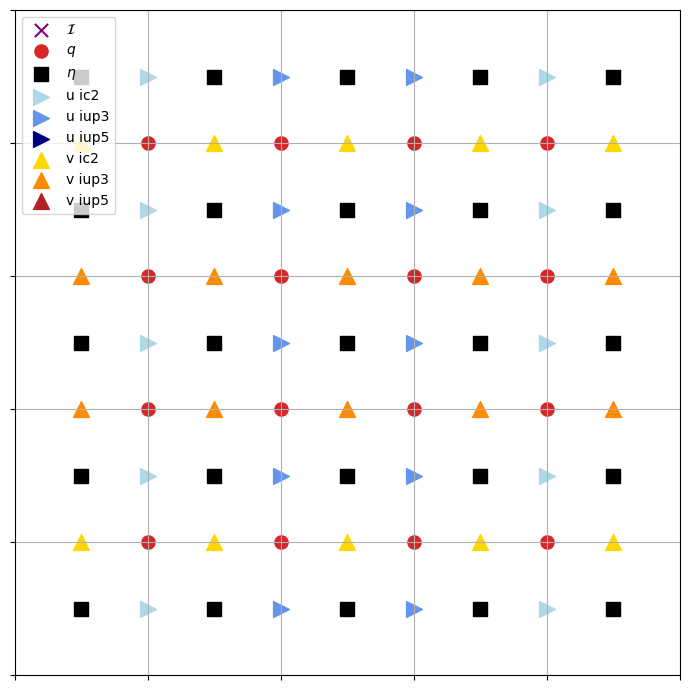

In [12]:
plt.ion()
fig,ax =plt.subplots(figsize=(7,7))
ax.imshow(h.values.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1, label="mask")
ax.set_xticks(np.arange(-.5,n+.5)), ax.set_yticks(np.arange(-.5,n+.5))

s = 90
s2 = 130


# PLOT BOUNDARIES
q_xmin, q_ymin = -.5, -.5
ax.scatter(q_xmin+1+q.irrbound_xids,q_ymin+1+q.irrbound_yids,
           s=s, marker='x', label='$\mathcal{I}$', color='purple')

# PLOT PV FUNCTION
q_xmin, q_ymin = -.5, -.5
mask_q_ids = jnp.argwhere(q.values.squeeze())
ax.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
          s=s, marker='o', label='$q$', color='tab:red')


# PLOT HEIGHT
s = 90
s2 = 130
h_xmin, h_ymin = 0, 0
mask_h_ids = jnp.argwhere(h.values.squeeze())
ax.scatter(h_xmin+mask_h_ids[:,0], h_ymin+mask_h_ids[:,1],
            s=s, marker='s', label='$\eta$', color='black')

# PLOT ZONAL VELOCITY
u_xmin, u_ymin = -.5, 0
mask_u_ids = jnp.argwhere(u.distbound1.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(u.distbound2.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(u.distbound3plus.squeeze())
ax.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

# PLOT MERIDIONAL VELOCITY
v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(v.distbound1.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(v.distbound2plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(v.distbound3plus.squeeze())
ax.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')


ax.grid()
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()